In [1]:
from dask.distributed import Client
client = Client()

/home/cdonnelly/excited-workflow/venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39121 instead
  warnings.warn(


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import pycaret.regression
import xarray as xr
import xarray_regrid  # Importing this will make Dataset.regrid accessible.
from dask.distributed import Client
from pycaret.classification import predict_model

import excited_workflow
from excited_workflow.source_datasets import datasets
from excited_workflow.train_models import carbon_tracker


def merge_datasets(desired_data: list[str], target: Path) -> xr.Dataset:
    """Merge datasets onto one common grid.
    
    Args:
        desired_data: list of desired datasets
        freq: time frequency that is desired
        target: target grid dataset

    Returns:
        Dataset of input variables.
    """
    ds_cb = xr.open_dataset(target)
    ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)
    ds_input = xr.merge([datasets[name].load(freq="monthly", target_grid=ds_cb) 
                         for name in desired_data])
    
    return ds_input


def mask_region(regions: Path,  
                target: Path, 
                ds_input: xr.Dataset
                ) -> xr.Dataset:
    """Limit data to a region and time slice."""
    ds_regions = xr.open_dataset(regions)
    ds_cb = xr.open_dataset(target)
    ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)
    ds_merged = xr.merge([
        ds_cb[["bio_flux_opt"]], 
        ds_regions["transcom_regions"],
        ds_input,
        ])
    time_region_na = {"time": slice("2000-01", "2019-12"), 
                      "latitude": slice(15, 60), 
                      "longitude": slice(-140, -55),
                      }
    ds_na = ds_merged.sel(time_region_na)
    ds_na = ds_na.compute()
    ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

    return ds_na

In [3]:
ds_cb = Path("/data/volume_2/EXCITED_prepped_data/CT2022.flux1x1-monthly.nc")
ds_regions = Path("/data/volume_2/EXCITED_prepped_data/regions.nc")

desired_data = [
    "biomass",
    "spei",
    "modis",
    "era5_monthly",
    "era5_land_monthly",
    "copernicus_landcover"
]

x_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt",
            "stl1", "swvl1", "lccs_class"]
y_key = "bio_flux_opt"

In [4]:
ds_input = merge_datasets(desired_data, ds_cb)
ds_input

<xarray.Dataset>
Dimensions:     (time: 385, latitude: 180, longitude: 360)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2022-01-01
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables: (12/24)
    biomass     (time, latitude, longitude) float64 dask.array<chunksize=(385, 180, 360), meta=np.ndarray>
    spei        (time, latitude, longitude) float32 dask.array<chunksize=(96, 180, 360), meta=np.ndarray>
    NDVI        (time, latitude, longitude) float32 dask.array<chunksize=(385, 180, 360), meta=np.ndarray>
    NIRv        (time, latitude, longitude) float32 dask.array<chunksize=(385, 180, 360), meta=np.ndarray>
    d2m         (time, latitude, longitude) float32 dask.array<chunksize=(132, 180, 360), meta=np.ndarray>
    mslhf       (time, latitude, longitude) float32 dask.array<chunksize=(132, 180, 360), meta=np.ndarray>
    ...          ...
    stl4        (time, latitude, longitude) float32 dask.array<chunksize=(132, 180, 360), meta=np.ndarray>
    swvl1       (time, latitude, longitude) float32 dask.array<chunksize=(132, 180, 360), meta=np.ndarray>
    swvl2       (time, latitude, longitude) float32 dask.array<chunksize=(132, 180, 360), meta=np.ndarray>
    swvl3       (time, latitude, longitude) float32 dask.array<chunksize=(132, 180, 360), meta=np.ndarray>
    swvl4       (time, latitude, longitude) float32 dask.array<chunksize=(132, 180, 360), meta=np.ndarray>
    lccs_class  (time, latitude, longitude) float32 dask.array<chunksize=(385, 180, 360), meta=np.ndarray>
Attributes:
    title:        Changes in Global Terrestrial Live Biomass over the 21st Ce...
    version:      2
    institution:  Jet Propulsion Laboratory, California Institute of Technology
    source:       Estimates of carbon stock changes of live woody biomass fro...
    history:      \n2022-08-18: downloaded source from https://zenodo.org/rec...
    references:   \n@Xu2021{\n  author = {Xu, Liang, Saatchi, Sassan S., Yang...

In [5]:
ds_na = mask_region(ds_regions, ds_cb, ds_input)
ds_na

<xarray.Dataset>
Dimensions:           (time: 240, latitude: 45, longitude: 85)
Coordinates:
  * longitude         (longitude) float64 -139.5 -138.5 -137.5 ... -56.5 -55.5
  * latitude          (latitude) float64 15.5 16.5 17.5 18.5 ... 57.5 58.5 59.5
  * time              (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
Data variables: (12/26)
    bio_flux_opt      (time, latitude, longitude) float64 nan nan ... nan nan
    transcom_regions  (latitude, longitude) float64 nan nan nan ... nan nan nan
    biomass           (time, latitude, longitude) float64 nan nan ... nan nan
    spei              (time, latitude, longitude) float64 nan nan ... nan nan
    NDVI              (time, latitude, longitude) float64 nan nan ... nan nan
    NIRv              (time, latitude, longitude) float64 nan nan ... nan nan
    ...                ...
    stl4              (time, latitude, longitude) float64 nan nan ... nan nan
    swvl1             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl2             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl3             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl4             (time, latitude, longitude) float64 nan nan ... nan nan
    lccs_class        (time, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    averaging_period_length_hours:  744
    email:                          carbontracker.team@noaa.gov
    url:                            http://carbontracker.noaa.gov
    institution:                    NOAA Earth System Research Laboratory
    Conventions:                    CF-1.5
    history:                        Time-stamp: <Orion-login-1.HPC.MsState.Ed...
    NCO:                            netCDF Operators version 4.9.3 (Homepage ...
    version:                        CT2022 1x1 3-hourly fluxes as of 2023-01-...

In [6]:
df_train = ds_na.to_dataframe().dropna()
df_train

bio_flux_opt  transcom_regions    biomass  \
time       latitude longitude                                              
2000-08-01 16.5     -97.5     -6.010017e-07               2.0  45.289826   
                    -96.5     -5.498427e-07               2.0  42.524410   
                    -95.5     -3.203208e-07               2.0  40.658878   
           17.5     -100.5    -7.650994e-07               2.0  46.187639   
                    -99.5     -2.389529e-06               2.0  41.231996   
...                                     ...               ...        ...   
2019-12-01 55.5     -114.5     5.078427e-07               2.0  23.803023   
                    -113.5     7.799189e-07               2.0  29.709211   
                    -112.5     8.044822e-07               2.0  15.008749   
           56.5     -131.5     5.528356e-07               2.0  64.364447   
           57.5     -132.5     1.015704e-07               2.0  13.424713   

                                   spei      NDVI      NIRv         d2m  \
time       latitude longitude                                             
2000-08-01 16.5     -97.5      0.402637  0.756299  0.264352  291.160736   
                    -96.5      0.859432  0.635423  0.186314  287.451385   
                    -95.5     -0.002091  0.714530  0.245570  292.602661   
           17.5     -100.5     0.364373  0.768887  0.270905  290.568329   
                    -99.5      0.007593  0.748444  0.249498  290.078156   
...                                 ...       ...       ...         ...   
2019-12-01 55.5     -114.5     0.650443  0.168989  0.014420  259.794739   
                    -113.5     0.582704  0.181974  0.015521  259.467133   
                    -112.5     0.328202  0.176154  0.017731  258.919037   
           56.5     -131.5    -0.181532 -0.066072 -0.038799  269.274261   
           57.5     -132.5     0.123489 -0.117813 -0.061499  266.016449   

                                    mslhf      msshf            sp  ...  \
time       latitude longitude                                       ...   
2000-08-01 16.5     -97.5     -123.552444 -29.256828  89704.265625  ...   
                    -96.5      -98.636139 -44.350342  83853.054688  ...   
                    -95.5      -88.933502 -76.770813  94853.679688  ...   
           17.5     -100.5    -118.364532 -51.205177  85797.492188  ...   
                    -99.5     -119.800644 -42.374344  85094.835938  ...   
...                                   ...        ...           ...  ...   
2019-12-01 55.5     -114.5      -2.107529  16.971649  92106.984375  ...   
                    -113.5      -1.547745  15.787460  92649.859375  ...   
                    -112.5      -0.648941  16.144135  93281.093750  ...   
           56.5     -131.5      -3.085175   0.307220  91528.421875  ...   
           57.5     -132.5      -1.342758  -2.474945  84002.898438  ...   

                                      skt        stl1        stl2        stl3  \
time       latitude longitude                                                   
2000-08-01 16.5     -97.5      293.800140  294.488708  294.490234  294.558624   
                    -96.5      291.346344  292.329987  292.415466  292.695587   
                    -95.5      298.976379  299.503906  299.532959  299.621643   
           17.5     -100.5     293.096253  293.790924  293.769348  293.723419   
                    -99.5      291.973236  292.737579  292.763458  292.868774   
...                                   ...         ...         ...         ...   
2019-12-01 55.5     -114.5     261.254547  272.136719  272.757507  274.221741   
                    -113.5     261.202423  268.530670  269.509583  273.085327   
                    -112.5     260.399170  268.575684  270.025513  273.835937   
           56.5     -131.5     265.012054  270.157807  270.336700  270.928772   
           57.5     -132.5     263.732574  267.186951  267.285309  267.666473   

                                    

In [7]:
target, prediction = carbon_tracker.train_model(df_train, x_keys, y_key)

,Description,Value
0,Session id,6895
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(26656, 13)"
4,Transformed data shape,"(26656, 13)"
5,Transformed train set shape,"(18659, 13)"
6,Transformed test set shape,"(7997, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.32,0.24,0.49,0.76,0.23,4.12,1.24
rf,Random Forest Regressor,0.33,0.25,0.50,0.75,0.23,4.32,4.33
lightgbm,Light Gradient Boosting Machine,0.33,0.25,0.50,0.75,0.23,4.30,0.12
gbr,Gradient Boosting Regressor,0.35,0.28,0.53,0.72,0.24,4.90,2.04
ridge,Ridge Regression,0.46,0.42,0.65,0.58,0.30,7.87,0.01
br,Bayesian Ridge,0.46,0.42,0.65,0.58,0.30,7.98,0.02
lar,Least Angle Regression,0.50,0.47,0.69,0.52,0.32,9.78,0.02
ada,AdaBoost Regressor,0.53,0.47,0.69,0.52,0.34,10.65,0.47
dt,Decision Tree Regressor,0.48,0.53,0.73,0.47,0.32,6.07,0.09
lr,Linear Regression,0.49,0.54,0.73,0.47,0.32,8.38,0.25


In [8]:
ct_path = Path("/data/volume_2/EXCITED_prepped_data/CT2022.flux1x1-monthly.nc")
ds_cb = xr.open_dataset(ct_path)
ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)

ds_cb[y_key]


<xarray.DataArray 'bio_flux_opt' (time: 252, latitude: 180, longitude: 360)>
[16329600 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
Attributes:
    units:         mol m-2 s-1
    cell_methods:  time: mean

,Description,Value
0,Session id,335
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(26656, 13)"
4,Transformed data shape,"(26656, 13)"
5,Transformed train set shape,"(18659, 13)"
6,Transformed test set shape,"(7997, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.32,0.23,0.48,0.76,0.22,4.20,1.23
rf,Random Forest Regressor,0.33,0.25,0.50,0.75,0.23,4.39,4.29
lightgbm,Light Gradient Boosting Machine,0.33,0.25,0.50,0.75,0.23,4.43,0.08
gbr,Gradient Boosting Regressor,0.35,0.27,0.52,0.72,0.24,5.12,2.04
ridge,Ridge Regression,0.45,0.42,0.65,0.57,0.30,7.78,0.02
br,Bayesian Ridge,0.46,0.42,0.65,0.57,0.30,7.73,0.01
ada,AdaBoost Regressor,0.53,0.48,0.69,0.52,0.35,10.99,0.47
lar,Least Angle Regression,0.51,0.49,0.69,0.51,0.32,9.04,0.01
dt,Decision Tree Regressor,0.47,0.50,0.71,0.49,0.32,6.28,0.09
lr,Linear Regression,0.49,0.53,0.73,0.46,0.32,8.25,0.02


2023-12-01 15:49:39,766 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-12-01 15:49:40,208 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-12-01 15:49:40,647 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-12-01 15:49:41,010 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-12-01 15:49:41,377 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-01 15:49:41,773 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-01 15:49:42,141 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-01 15:49:42,530 - distributed.utils_perf - WARNING - full garbage collections took

2023-12-01 15:51:22,546 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-12-01 15:51:22,918 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


,Description,Value
0,Session id,8268
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(21325, 13)"
4,Transformed data shape,"(21325, 13)"
5,Transformed train set shape,"(14927, 13)"
6,Transformed test set shape,"(6398, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.33,0.25,0.50,0.77,0.23,3.10,3.26
et,Extra Trees Regressor,0.32,0.24,0.49,0.77,0.22,3.15,0.98
lightgbm,Light Gradient Boosting Machine,0.33,0.25,0.50,0.77,0.23,3.50,0.07
gbr,Gradient Boosting Regressor,0.35,0.28,0.53,0.74,0.24,4.98,1.63
ridge,Ridge Regression,0.46,0.44,0.66,0.59,0.30,6.41,0.01
br,Bayesian Ridge,0.47,0.44,0.66,0.59,0.30,6.35,0.01
ada,AdaBoost Regressor,0.49,0.45,0.67,0.58,0.31,8.32,0.38
lar,Least Angle Regression,0.49,0.47,0.68,0.57,0.31,6.37,0.01
dt,Decision Tree Regressor,0.47,0.51,0.72,0.52,0.31,5.71,0.07
lr,Linear Regression,0.51,0.57,0.75,0.47,0.32,8.64,0.02


2023-12-01 15:51:25,389 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-12-01 15:51:25,823 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-01 15:51:26,162 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-01 15:51:26,550 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-01 15:51:26,911 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-01 15:51:27,287 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-01 15:51:27,763 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-01 15:51:28,103 - distributed.utils_perf - WARNING - full garbage collections took

2023-12-01 15:52:47,596 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


,Description,Value
0,Session id,7302
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(21325, 13)"
4,Transformed data shape,"(21325, 13)"
5,Transformed train set shape,"(14927, 13)"
6,Transformed test set shape,"(6398, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.33,0.24,0.49,0.76,0.23,3.72,0.98
rf,Random Forest Regressor,0.33,0.25,0.50,0.75,0.23,3.56,3.33
lightgbm,Light Gradient Boosting Machine,0.33,0.25,0.50,0.75,0.23,4.27,0.07
gbr,Gradient Boosting Regressor,0.35,0.27,0.52,0.73,0.24,5.11,1.61
ada,AdaBoost Regressor,0.47,0.40,0.64,0.59,0.30,12.15,0.37
ridge,Ridge Regression,0.46,0.43,0.66,0.57,0.30,7.33,0.01
br,Bayesian Ridge,0.46,0.43,0.66,0.57,0.30,7.45,0.01
lar,Least Angle Regression,0.47,0.44,0.66,0.56,0.30,6.95,0.01
dt,Decision Tree Regressor,0.47,0.50,0.71,0.49,0.32,7.52,0.07
lr,Linear Regression,0.50,0.54,0.73,0.46,0.32,9.22,0.01


2023-12-01 15:52:49,982 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-12-01 15:52:50,371 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-12-01 15:52:50,709 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-12-01 15:52:51,116 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2023-12-01 15:52:51,515 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-01 15:52:51,893 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-01 15:52:52,234 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2023-12-01 15:52:52,560 - distributed.utils_perf - WARNING - full garbage collections took

2023-12-01 15:54:13,763 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


,Description,Value
0,Session id,5648
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(21325, 13)"
4,Transformed data shape,"(21325, 13)"
5,Transformed train set shape,"(14927, 13)"
6,Transformed test set shape,"(6398, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.33,0.25,0.50,0.76,0.23,4.43,1.00
rf,Random Forest Regressor,0.33,0.26,0.51,0.75,0.23,4.62,3.31
lightgbm,Light Gradient Boosting Machine,0.34,0.26,0.51,0.75,0.23,4.65,0.07
gbr,Gradient Boosting Regressor,0.35,0.28,0.53,0.73,0.24,5.34,1.61
ridge,Ridge Regression,0.46,0.44,0.66,0.58,0.30,8.15,0.01
br,Bayesian Ridge,0.46,0.44,0.66,0.58,0.30,8.11,0.02
ada,AdaBoost Regressor,0.50,0.44,0.66,0.57,0.32,10.29,0.37
dt,Decision Tree Regressor,0.48,0.52,0.72,0.50,0.32,6.67,0.07
lr,Linear Regression,0.50,0.55,0.74,0.46,0.32,9.27,0.02
en,Elastic Net,0.51,0.58,0.76,0.44,0.33,8.56,0.02


2023-12-01 15:54:16,230 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-01 15:54:16,684 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-01 15:54:17,054 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-01 15:54:17,475 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-12-01 15:54:17,828 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-12-01 15:54:18,230 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-12-01 15:54:18,580 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-12-01 15:54:19,001 - distributed.utils_perf - WARNING - full garbage collections took

2023-12-01 15:55:38,981 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


,Description,Value
0,Session id,3678
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(21325, 13)"
4,Transformed data shape,"(21325, 13)"
5,Transformed train set shape,"(14927, 13)"
6,Transformed test set shape,"(6398, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.32,0.24,0.49,0.75,0.23,4.12,0.97
rf,Random Forest Regressor,0.33,0.25,0.50,0.74,0.23,4.50,3.36
lightgbm,Light Gradient Boosting Machine,0.33,0.25,0.50,0.74,0.23,4.15,0.07
gbr,Gradient Boosting Regressor,0.35,0.27,0.52,0.72,0.24,4.65,1.60
ada,AdaBoost Regressor,0.47,0.40,0.63,0.59,0.30,8.42,0.36
ridge,Ridge Regression,0.45,0.42,0.64,0.57,0.29,7.31,0.01
br,Bayesian Ridge,0.45,0.42,0.64,0.57,0.29,7.39,0.02
lar,Least Angle Regression,0.47,0.44,0.67,0.54,0.31,7.86,0.01
dt,Decision Tree Regressor,0.47,0.50,0.71,0.48,0.32,6.41,0.07
lr,Linear Regression,0.49,0.52,0.72,0.47,0.31,7.63,0.02


2023-12-01 15:55:41,422 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-01 15:55:41,897 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-01 15:55:42,304 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-12-01 15:55:42,741 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-12-01 15:55:43,133 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-12-01 15:55:43,510 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-12-01 15:55:43,958 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2023-12-01 15:55:44,367 - distributed.utils_perf - WARNING - full garbage collections took

2023-12-01 15:57:05,562 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were fou

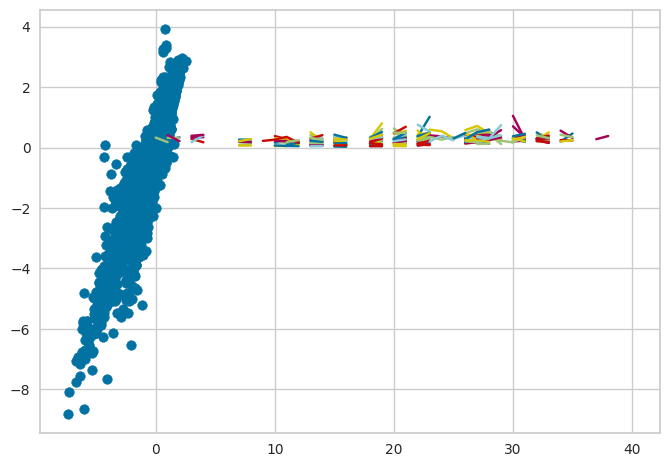

In [9]:
validation = carbon_tracker.validate_model(ds_na, 5, x_keys, y_key)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

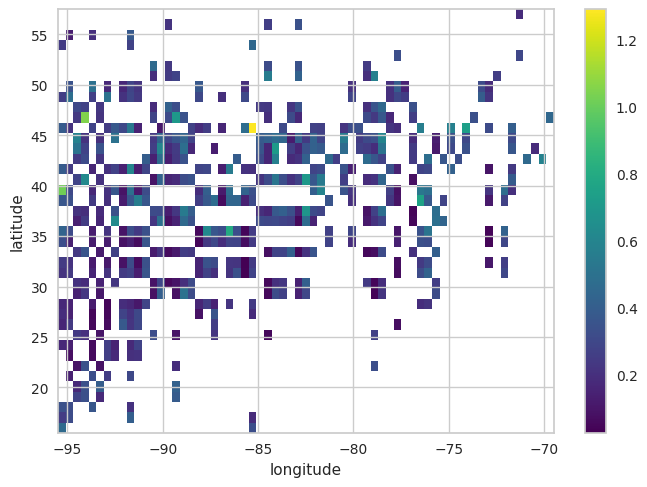

In [20]:
import matplotlib.pyplot as plt
validation.plot.imshow()